In [9]:
import habitat

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from PIL import Image
import uuid
import os
import shutil
from typing import Any
import quaternion
import random
from env import Env
import matplotlib.colors as mcolors
from utils import draw_top_down_map, AgentPosition
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

In [13]:
config = habitat.get_config("/data_config/challenge_objectnav2020.local.rgbd.yaml")

config.defrost()

config.DATASET.DATA_PATH = '/data/datasets/objectnav/mp3d/v1/{split}/{split}.json.gz'
config.DATASET.SCENES_DIR = '/data/scene_datasets'
config.DATASET.SPLIT = "train"

config.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True
#config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.01
#config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.0

H = 320
W = 640

config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = H
config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = W

config.PYROBOT.RGB_SENSOR.HEIGHT = H
config.PYROBOT.RGB_SENSOR.WIDTH = W
config.PYROBOT.DEPTH_SENSOR.HEIGHT = H
config.PYROBOT.DEPTH_SENSOR.WIDTH = W

config.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True

config.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')

config.SIMULATOR.TURN_ANGLE = 5
config.SIMULATOR.TILT_ANGLE = 5
config.SIMULATOR.FORWARD_STEP_SIZE = 0.15

config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS.append("HEADING_SENSOR")
config.TASK.SENSORS.append("GPS_SENSOR")
config.TASK.GPS_SENSOR.DIMENSIONALITY = 2
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"

config.TASK.AGENT_POSITION_SENSOR = habitat.Config()
config.TASK.AGENT_POSITION_SENSOR.TYPE = "my_supercool_sensor"
config.TASK.AGENT_POSITION_SENSOR.ANSWER_TO_LIFE = 42
config.TASK.SENSORS.append("AGENT_POSITION_SENSOR")

config.freeze()

In [14]:
env = Env(config)

2020-07-16 10:33:16,314 Initializing dataset ObjectNav-v1
Initializing dataset ObjectNav-v1
2020-07-16 10:37:25,168 initializing sim Sim-v0
initializing sim Sim-v0
2020-07-16 10:37:29,591 Initializing task ObjectNav-v1
Initializing task ObjectNav-v1
The answer to life is 42


In [15]:
DATASET_DIRECTORY_X = '/root/Obj_dataset/X'
DATASET_DIRECTORY_Y = '/root/Obj_dataset/Y'
if os.path.exists(DATASET_DIRECTORY_X):
    shutil.rmtree(DATASET_DIRECTORY_X)
    shutil.rmtree(DATASET_DIRECTORY_Y)
os.makedirs(DATASET_DIRECTORY_X)
os.makedirs(DATASET_DIRECTORY_Y)

In [16]:
def prepare_semantic_observation(observations):
    scene = env.sim.semantic_annotations()
    instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
    mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

    return np.take(mapping, observations['semantic'])

In [17]:
index_to_title_map2 = {i.category.index(): i.category.name() for i in env.sim.semantic_annotations().objects}
index_to_title_map2[-1] = 'nope'
print(len(index_to_title_map2))
print(index_to_title_map2)

31
{1: 'wall', 17: 'ceiling', 40: 'misc', 12: 'curtain', 0: 'void', 11: 'bed', 22: 'tv_monitor', -1: 'nope', 13: 'chest_of_drawers', 8: 'cushion', 2: 'floor', 28: 'lighting', 5: 'table', 4: 'door', 20: 'towel', 23: 'shower', 15: 'sink', 21: 'mirror', 38: 'clothes', 39: 'objects', 19: 'stool', 18: 'toilet', 7: 'cabinet', 26: 'counter', 10: 'sofa', 32: 'blinds', 36: 'furniture', 3: 'chair', 6: 'picture', 31: 'shelving', 37: 'appliances'}


In [9]:
observations, info, done = env.reset()

In [18]:
def save_image_for_dataset(observations):
    rgb = observations['rgb']
    
    image = Image.fromarray(rgb)
    u = uuid.uuid1()
    
    image.save(DATASET_DIRECTORY_X + "/" + str(u) + '.png')
    
#     semantic = prepare_semantic_observation(observations)
    semantic = observations['semantic']
    
    unique_values = np.unique(semantic)
       
    objects = []
    
    os.mkdir(DATASET_DIRECTORY_Y + "/" + str(u))
    
    for value in unique_values:
        obj = (semantic == value)
        
        scene = env.sim.semantic_annotations()
        instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
        
        title = str(instance_id_to_label_id[value])
        
        image = Image.fromarray(obj)
        image.save(DATASET_DIRECTORY_Y + "/" + str(u) + "/" + title + ".png")

In [21]:
scene = env.sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])
index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }

In [23]:
def check_action(cur_action, last_action, is_bump):
    if is_bump and cur_action == 'MOVE_FORWARD':
        return False
    
    if cur_action == 'TURN_LEFT' and last_action == 'TURN_RIGHT':
        return False
    if cur_action == 'TURN_RIGHT' and last_action == 'TURN_LEFT':
        return False

    return True

In [24]:
def get_random_action(last, is_bump):
    action = random.choice(list(action_mapping))

    while not(check_action(action, last, is_bump)):
        action = random.choice(list(action_mapping))

    return action

In [25]:
class Saver:
    def __init__(self):
        self.count = 0
        self.path = 'images'
        self.all_positions = {}
        
    def save_image(self, observations, env):
        cur_scene = env.current_episode.scene_id
        
        if self.check_exist_image(observations, cur_scene):
            return;

        save_image_for_dataset(observations)

        self.count += 1
        scene = env.sim.semantic_annotations()
        if cur_scene in self.all_positions:
            self.all_positions[cur_scene] = np.append(self.all_positions[cur_scene], [observations['agent_position']], axis=0)
        else:
            self.all_positions[cur_scene] = np.array([observations['agent_position']])
        
    def check_exist_image(self, observations, cur_scene):
        cur_position = observations['agent_position']
        
        if not(cur_scene in self.all_positions):
            return False
        
        min_diff = np.sqrt(np.square(self.all_positions[cur_scene] - cur_position).sum(axis=1).min())
        
        return min_diff <= 2

In [26]:
def check_bump(last_observations, observations):
    return np.sqrt(np.square(last_observations['agent_position'] - observations['agent_position']).sum()) <= 0.5

In [27]:
action_mapping = {
    1: 'MOVE_FORWARD',
    2: 'TURN_LEFT',
    3: 'TURN_RIGHT'
}

In [28]:
saver = Saver()

index = 0
ii=0
done = False
mapper = []
maps = []


for i in range(len(env.episodes)):
    
    observations, info, done = env.reset()
    
    mapper.append(observations['objectgoal'][0])

    last = ''
    is_bump = False

    while not done:
        
        action = 0

        last_observations = observations
        
        observations, info, done = env.step(action,ideal_action=True)

        is_bump = check_bump(last_observations, observations)
            
        index += 1

        saver.save_image(observations, env)
    
    ii+=1
    top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
    maps.append(top_down_map)
    print(ii,'\t',index)
    
    if index >= 100000:
        break

1 	 500
2 	 1000
3 	 1500
4 	 2000
5 	 2500
6 	 3000
7 	 3500
8 	 4000
9 	 4500
10 	 5000
11 	 5500
12 	 6000
13 	 6500
14 	 7000
15 	 7500
16 	 8000
17 	 8500
18 	 9000
19 	 9500
20 	 10000
21 	 10500
22 	 11000
23 	 11500
24 	 12000
25 	 12500
26 	 13000
27 	 13500
28 	 14000
29 	 14500
30 	 15000
31 	 15028
32 	 15528
33 	 16028
34 	 16528
35 	 17028
36 	 17155
37 	 17655
38 	 18155
39 	 18655
40 	 19155
41 	 19235
42 	 19735
43 	 20235
44 	 20735
45 	 21235
46 	 21735
47 	 22235
48 	 22735
49 	 23235
50 	 23735
51 	 24235
52 	 24291
53 	 24469
54 	 24543
55 	 24918
56 	 25064
57 	 25339
58 	 25634
59 	 25753
60 	 25820
61 	 26169
62 	 26288
63 	 26435
64 	 26815
65 	 26919
66 	 27121
67 	 27217
68 	 27588
69 	 27650
70 	 27743
71 	 27904
72 	 28279
73 	 28407
74 	 28510
75 	 28705
76 	 28798
77 	 28924
78 	 29015
79 	 29344
80 	 29545
81 	 29909
82 	 30173
83 	 30317
84 	 30602
85 	 30726
86 	 30916
87 	 31012
88 	 31201
89 	 31296
90 	 31651
91 	 31720
92 	 31820
93 	 31871
94 	 3

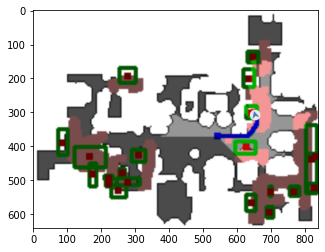

In [29]:
plt.imshow(maps[100])

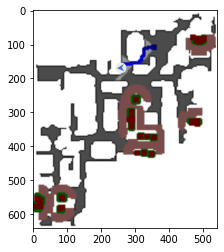

In [30]:
if os.path.exists('/root/dataset_maps'):
    shutil.rmtree('/root/dataset_maps')
os.makedirs('/root/dataset_maps')
i = 0
for mapp in maps:
    plt.imshow(mapp)
    plt.savefig('/root/dataset_maps/map_{}.png'.format(i))
    i+=1